In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import PercentFormatter


from matplotlib.lines import Line2D

ashley this is going to be very lazy code, I make no apologies

In [2]:
# bar = pd.read_csv('/Users/user/Downloads/bar-classifications.csv')
# spiral = pd.read_csv('/Users/user/Downloads/spiral-classifications.csv')
# len(bar), len(spiral)

df = pd.read_csv('/Users/user/Downloads/galaxy-judges-classifications.csv')[:500]
spiral = df.query('workflow_name == "Spiral"')
bar = df.query('workflow_name == "Bar"')

In [32]:
len(spiral), len(bar)

(367, 133)

In [3]:
bar.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
9,513560862,not-logged-in-b5382d1a8bc756974c12,NaN,b5382d1a8bc756974c12,25255,Bar,23.31,2023-09-29 12:34:49 UTC,NaN,NaN,"{""source"":""api"",""session"":""6f976fd4ea38c92ba30...","[{""task"":""T0"",""task_label"":""Which algorithm be...","{""92122936"":{""retired"":null,""Filename"":""371107...",92122936
10,513560933,not-logged-in-081aee4e90b77b6d9419,NaN,081aee4e90b77b6d9419,25255,Bar,23.31,2023-09-29 12:35:22 UTC,NaN,NaN,"{""source"":""api"",""session"":""6f976fd4ea38c92ba30...","[{""task"":""T0"",""task_label"":""Which algorithm be...","{""92122948"":{""retired"":null,""Filename"":""441329...",92122948
11,513560949,not-logged-in-081aee4e90b77b6d9419,NaN,081aee4e90b77b6d9419,25255,Bar,23.31,2023-09-29 12:35:36 UTC,NaN,NaN,"{""source"":""api"",""session"":""6f976fd4ea38c92ba30...","[{""task"":""T0"",""task_label"":""Which algorithm be...","{""92122919"":{""retired"":null,""Filename"":""612183...",92122919
12,513560980,not-logged-in-081aee4e90b77b6d9419,NaN,081aee4e90b77b6d9419,25255,Bar,23.31,2023-09-29 12:36:07 UTC,NaN,NaN,"{""source"":""api"",""session"":""6f976fd4ea38c92ba30...","[{""task"":""T0"",""task_label"":""Which algorithm be...","{""92122939"":{""retired"":null,""Filename"":""322595...",92122939
13,513561133,not-logged-in-5b7167164481acec4bb7,NaN,5b7167164481acec4bb7,25255,Bar,23.31,2023-09-29 12:38:01 UTC,NaN,NaN,"{""source"":""api"",""session"":""6f976fd4ea38c92ba30...","[{""task"":""T0"",""task_label"":""Which algorithm be...","{""92122928"":{""retired"":null,""Filename"":""395590...",92122928


In [4]:
bar.iloc[0]['annotations']

'[{"task":"T0","task_label":"Which algorithm best identifies the bars?","value":"Top row"},{"task":"T1","task_label":"How did the best algorithm do?","value":"Perfectly"},{"task":"T2","task_label":"How did the other algorithm do?","value":"Mostly well (some minor errors)"}]'

In [5]:


quality_renamer = {
    'Perfectly': 'perfect',
    'Mostly well (some minor errors)': 'mostly',
    'Mostly well, some small errors': 'mostly',
    'Mostly poorly (some major errors)': 'poorly',
    'Mostly poorly, some major errors': 'poorly',
    'Totally failed': 'failed'
}

bar_namer = {
    'Top row': 'gz3d',
    'Bottom row': 'zoobot-3d'
}

spiral_namer = {
    'Top row': 'sparcfire',
    'Middle row': 'gz3d',
    'Bottom row': 'zoobot-3d'
}
    
    

def load_bar_annotations(annotation_str):
    annotations = json.loads(annotation_str)
    if len(annotations) == 1:
        assert annotations[0]['value'] == "I can't decide, they're so similar!"
        return {
            'best_algorithm': 'tie'
        }
    assert len(annotations) == 3, len(annotations)
    return {
        'best_algorithm': bar_namer[annotations[0]['value']],
        'best_quality': quality_renamer[annotations[1]['value']],
        'second_quality': quality_renamer[annotations[2]['value']],
    }

def load_spiral_annotations(annotation_str):
    annotations = json.loads(annotation_str)
    assert len(annotations) == 4, len(annotations)
    return {
        'best_algorithm': spiral_namer[annotations[0]['value']],
        'best_quality': quality_renamer[annotations[1]['value']],
        'second_algorithm': spiral_namer[annotations[2]['value']],
        'second_quality': quality_renamer[annotations[3]['value']],
    }

In [6]:
load_bar_annotations(bar['annotations'].iloc[0])

{'best_algorithm': 'gz3d',
 'best_quality': 'perfect',
 'second_quality': 'mostly'}

In [7]:
load_spiral_annotations(spiral['annotations'].iloc[0])

{'best_algorithm': 'zoobot-3d',
 'best_quality': 'mostly',
 'second_algorithm': 'gz3d',
 'second_quality': 'mostly'}

In [8]:
bar_df = pd.DataFrame(data=bar['annotations'].apply(load_bar_annotations).tolist())
bar_df

,best_algorithm,best_quality,second_quality
0,gz3d,perfect,mostly
1,gz3d,poorly,poorly
2,gz3d,perfect,mostly
3,zoobot-3d,perfect,mostly
4,zoobot-3d,mostly,mostly
...,...,...,...
128,zoobot-3d,mostly,poorly
129,tie,NaN,NaN
130,tie,NaN,NaN
131,gz3d,perfect,mostly


In [29]:
bar_df['best_algorithm'].value_counts(normalize=True)  # gz3d won 15 times

zoobot-3d    0.676692
tie          0.210526
gz3d         0.112782
Name: best_algorithm, dtype: float64

In [10]:
zoobot_quality_when_best = bar_df.query('best_algorithm == "zoobot-3d"')['best_quality'].value_counts()
zoobot_quality_when_best['failed'] = zoobot_quality_when_best.get('failed', 0)
zoobot_quality_when_worst = bar_df.query('best_algorithm == "gz3d"')['second_quality'].value_counts()
zoobot_quality_when_worst['perfect'] = zoobot_quality_when_worst.get('perfect', 0)
zoobot_quality_when_worst['failed'] = zoobot_quality_when_worst.get('failed', 0)

zoobot_quality_when_best + zoobot_quality_when_worst

failed      0
mostly     63
perfect    22
poorly     20
dtype: int64

In [11]:
gz3d_quality_when_best = bar_df.query('best_algorithm == "gz3d"')['best_quality'].value_counts()
gz3d_quality_when_best['failed'] = gz3d_quality_when_best.get('failed', 0)
gz3d_quality_when_worst = bar_df.query('best_algorithm == "zoobot-3d"')['second_quality'].value_counts()
gz3d_quality_when_worst['perfect'] = gz3d_quality_when_worst.get('perfect', 0)
gz3d_quality_when_worst['failed'] = gz3d_quality_when_worst.get('failed', 0)

gz3d_quality_when_best + gz3d_quality_when_worst

failed     16
mostly     44
perfect     7
poorly     38
dtype: int64

In [12]:
((bar_df['best_algorithm'] != "zoobot-3d")).sum()  # only 2 was zoobot rated worst, negligible - but include as 'failed' in the below manually

43

## repeat for spirals

In [13]:
spiral_df = pd.DataFrame(data=spiral['annotations'].apply(load_spiral_annotations).tolist())
spiral_df

,best_algorithm,best_quality,second_algorithm,second_quality
0,zoobot-3d,mostly,gz3d,mostly
1,gz3d,mostly,zoobot-3d,mostly
2,zoobot-3d,mostly,gz3d,mostly
3,zoobot-3d,perfect,gz3d,mostly
4,zoobot-3d,perfect,gz3d,mostly
...,...,...,...,...
362,gz3d,mostly,zoobot-3d,mostly
363,gz3d,perfect,zoobot-3d,mostly
364,zoobot-3d,mostly,gz3d,mostly
365,gz3d,perfect,gz3d,mostly


In [14]:
spiral_df['best_algorithm'].value_counts(normalize=True)

zoobot-3d    0.782016
gz3d         0.204360
sparcfire    0.013624
Name: best_algorithm, dtype: float64

In [15]:
# sparcfire beats zoobot if sparcfire is either best, or, gz3d is best and sparcfire is second 
sparcfire_best = spiral_df['best_algorithm'].isin(['sparcfire'])
sparcfire_second = (spiral_df['best_algorithm'].isin(['gz3d'])) & (spiral_df['second_algorithm'].isin(['sparcfire']))
sparcfire_best.mean(), sparcfire_second.mean()

(0.013623978201634877, 0.0)

In [16]:
# gz3d beats zoobot if gz3d is best, or, sparcfire is best and gz3d is second 
gz3d_best = spiral_df['best_algorithm'].isin(['gz3d'])
gz3d_second = (spiral_df['best_algorithm'].isin(['sparcfire'])) & (spiral_df['second_algorithm'].isin(['gz3d']))
gz3d_best.mean(), gz3d_second.mean()

(0.20435967302452315, 0.0)

In [17]:
spiral_df['second_algorithm']

0           gz3d
1      zoobot-3d
2           gz3d
3           gz3d
4           gz3d
         ...    
362    zoobot-3d
363    zoobot-3d
364         gz3d
365         gz3d
366    zoobot-3d
Name: second_algorithm, Length: 367, dtype: object

In [18]:
287/(287+75+5)

0.782016348773842

In [19]:
spiral_df['second_algorithm'].value_counts()

gz3d         281
zoobot-3d     78
sparcfire      8
Name: second_algorithm, dtype: int64

In [20]:
((spiral_df['best_algorithm'] != "zoobot-3d") & (spiral_df['second_algorithm'] != "zoobot-3d")).sum()  # only 2 was zoobot rated worst, negligible - but include as 'failed' in the below manually

2

In [21]:
zoobot_quality_when_best = spiral_df.query('best_algorithm == "zoobot-3d"')['best_quality'].value_counts()
zoobot_quality_when_middle = spiral_df.query('second_algorithm == "zoobot-3d"')['second_quality'].value_counts()
# zoobot_quality_when_worst = spiral_df.query('best_algorithm == "gz3d"')['second_quality'].value_counts()  # actually didn't measure
zoobot_quality_when_middle['perfect'] = zoobot_quality_when_middle.get('perfect', 0)
zoobot_quality_when_middle['failed'] = zoobot_quality_when_middle.get('failed', 0)
zoobot_quality_when_best['failed'] = zoobot_quality_when_middle.get('failed', 0)

zoobot_quality_when_best + zoobot_quality_when_middle

failed       0
mostly     223
perfect    105
poorly      37
dtype: int64

In [22]:
gz3d_quality_when_best = spiral_df.query('best_algorithm == "gz3d"')['best_quality'].value_counts()
gz3d_quality_when_middle = spiral_df.query('second_algorithm == "gz3d"')['second_quality'].value_counts()
# gz3d_quality_when_worst = spiral_df.query('best_algorithm == "gz3d"')['second_quality'].value_counts()  # actually didn't measure
gz3d_quality_when_middle['perfect'] = gz3d_quality_when_middle.get('perfect', 0)
gz3d_quality_when_middle['failed'] = gz3d_quality_when_middle.get('failed', 0)
gz3d_quality_when_best['failed'] = gz3d_quality_when_middle.get('failed', 0)

gz3d_quality_when_best + gz3d_quality_when_middle

failed       4
mostly     244
perfect     27
poorly      83
dtype: int64

In [31]:
(244 + 27) / (244 + 27 + 4 + 83)

0.7569832402234636

In [23]:
zoobot_worst = spiral_df['best_algorithm'].isin(['gz3d', 'sparcfire']) & spiral_df['second_algorithm'].isin(['gz3d', 'sparcfire'])
zoobot_worst.sum()

2

In [24]:
gz3d_worst = spiral_df['best_algorithm'].isin(['zoobot-3d', 'sparcfire']) & spiral_df['second_algorithm'].isin(['zoobot-3d', 'sparcfire'])
gz3d_worst.sum()

13

In [25]:
sparcfire_worst = spiral_df['best_algorithm'].isin(['gz3d', 'zoobot-3d']) & spiral_df['second_algorithm'].isin(['zoobot-3d', 'gz3d'])
sparcfire_worst.sum()

354

In [26]:
len(spiral_df) - 354

13

In [27]:

spiral_counts = {
    'zoobot-3d': (spiral_df['best_algorithm'] == 'zoobot-3d').mean(),
    'gz3d': (spiral_df['best_algorithm'] == 'gz3d').mean(),
    'sparcfire': (spiral_df['best_algorithm'] == 'sparcfire').mean(),
}
bar_counts = {
    'zoobot-3d': (bar_df['best_algorithm'] == 'zoobot-3d').mean(),
    'tie': (bar_df['best_algorithm'] == 'tie').mean(),
    'gz3d': (bar_df['best_algorithm'] == 'gz3d').mean()
}
bar_counts

{'zoobot-3d': 0.6766917293233082,
 'tie': 0.21052631578947367,
 'gz3d': 0.11278195488721804}

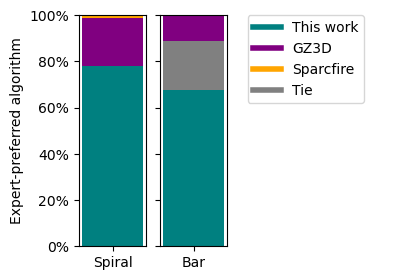

In [28]:

zoobot_color = 'teal'
sparcfire_color = 'orange'
gz3d_color = 'purple'
tie_color = 'gray'

fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(4, 3), ncols=4, sharey=True)

width = .1
bottom = 0
color_index = 0
for algorithm, weight_count in spiral_counts.items():
    colors = [zoobot_color, gz3d_color, sparcfire_color]
    p = ax0.bar(['Spiral'], weight_count, width, label=algorithm, bottom=bottom, color=colors[color_index])
    bottom += weight_count
    color_index += 1
bottom = 0
color_index = 0
for algorithm, weight_count in bar_counts.items():
    colors = [zoobot_color, tie_color, gz3d_color]
    p = ax1.bar(['Bar'], weight_count, width, label=algorithm, bottom=bottom, color=colors[color_index])
    bottom += weight_count
    color_index += 1

ax0.yaxis.set_major_formatter(PercentFormatter(1))


custom_lines = [
    Line2D([0], [0], color=zoobot_color, lw=4),
    Line2D([0], [0], color=gz3d_color, lw=4),
    Line2D([0], [0], color=sparcfire_color, lw=4),
    Line2D([0], [0], color=tie_color, lw=4)
]
ax0.legend(custom_lines, ['This work', 'GZ3D', 'Sparcfire', 'Tie'], loc=(2.5, .62))

ax2.axis('off')
ax3.axis('off')

ax0.set_ylim([0., 1.])

ax0.set_ylabel('Expert-preferred algorithm')

fig.savefig('expertpreferences.pdf', bbox_inches='tight')